In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error

import catboost as ctb
from catboost import CatBoostRegressor, cv, Pool
from catboost.utils import select_threshold, get_fpr_curve, get_roc_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import download
from nltk.corpus import stopwords
from pymystem3 import Mystem
import re
import gensim
from fse import IndexedList
from fse.models import Average
from gensim.models import KeyedVectors

bad_symbols_re = re.compile('[,.«»!"#$%&\'()*+/:;<=>?@[\\]^_`{|}~]')
stopwords = stopwords.words(['russian', 'english'])
mystem = Mystem()

import sys
sys.path.append("/data1/vovan/shared_code/")
import shared_utils
import utils

%matplotlib inline
pd.set_option('max_column', None)

## Данные

In [2]:
train_df = pd.read_csv("./data/train_issues.csv")
train_comment_df = pd.read_csv("./data/train_comments.csv")
test_df = pd.read_csv("./data/test_issues.csv")
test_comment_df = pd.read_csv("./data/test_comments.csv")
emp_df = pd.read_csv("./data/employees.csv")
solution_df = pd.read_csv("./data/sample_solution.csv")
summary_translated_df = pd.read_csv('./data/summary_translated.csv')


## Features

### general text
- разные языки, смешивание языков
- специальные знаки - название страниц
- разные регистры

In [3]:
# load features
tfidf_features_df = pd.read_csv('./data/tf-idf/summary_lemma_tfidf_250.csv')
if 'overall_worklogs' in tfidf_features_df.columns:
    tfidf_features_df.drop(['overall_worklogs'], 1, inplace = True)
    
# features
tfidf_features = [x for x in tfidf_features_df.columns if 'tf_idf' in x]
    
# merge tf-idf features
train_df = train_df.merge(tfidf_features_df, on = ['id'], how = 'left', validate = '1:1')
test_df = test_df.merge(tfidf_features_df, on = ['id'], how = 'left', validate = '1:1')

In [4]:
# load sim w2v features
sim_features = []
for file, file_prefix in [
    (f'./data/similarity_w2v/summary_translated_lemma_w2v_pretrained.csv', 'tr_lemm_pretrained_'),
    (f'./data/similarity_w2v/summary_translated_stem_basic.csv', 'tr_stem_basic_'),
    (f'./data/similarity_w2v/summary_translated_stem_intersect_lev.csv', 'tr_stem_intersect_'),
    (f'./data/similarity_w2v/summary_stem_basic.csv', 'or_stem_basic_'),
    (f'./data/similarity_w2v/summary_lemma_basic.csv', 'or_lemma_basic_'),

]:
    sim_df = pd.read_csv(file)
    sim_df.columns = [x if x == 'id' else file_prefix + x for x in sim_df.columns ] 
    sim_features.extend(list(sim_df.columns.values[1:]))
    
    train_df = train_df.merge(sim_df, on = ['id'], how = 'left', validate = '1:1')
    test_df = test_df.merge(sim_df, on = ['id'], how = 'left', validate = '1:1')

### general
- project_id полное пересечение
- assignee_id нет 3х в трейне
- creator_id нет 1го в трейне
- кол-во задач = кол-ву строк
- есть дубликаты по key задачи, но они похоже с разных месяцев (разница 3 мес)
- почему id идут в обратном порядке от задач?
- как проходило разбиение на трейн / тест по времени ?
- тест дальше по времени нежели тест

(на момент времени x)
- кол-во задач у сотрудника - пересечение по времени (+оценка сложности пересекающихся задач эвристически?)
- кодирование assigne / creator - среднее время последних задач N  
- day/hour/project/assigne - сколько создавалось задач (в разных разрезах) - не смотрим в будущее
- переработки, кол-во переработок, время переработок (до этого момента)

(прост)
- отпуска - попробовать выявить период бездействия assigne? время с отпуска и.т.д
- праздники (календарь) - по локации сотрудника?
- автоматизация (тип тестирование?) / default время решения задачи

In [6]:
# time basics
train_df = utils.time_features(train_df)
test_df = utils.time_features(test_df)

In [7]:
# same people
train_df['same_creator_and_assignee']= (train_df['assignee_id'] == train_df['creator_id']).astype('int')
test_df['same_creator_and_assignee']= (test_df['assignee_id'] == test_df['creator_id']).astype('int')

In [8]:
# summary basic encodes
train_df['summary_len'] = train_df['summary'].map(lambda x: len(x))
train_df['summary_word_len'] = train_df['summary'].map(lambda x: len(x.split(' ')))

test_df['summary_len'] = test_df['summary'].map(lambda x: len(x))
test_df['summary_word_len'] = test_df['summary'].map(lambda x: len(x.split(' ')))

In [9]:
# key first part
train_df['key_cat'] = train_df['key'].apply(lambda x: x.split('-')[0])
test_df['key_cat'] = test_df['key'].apply(lambda x: x.split('-')[0])

In [10]:
# project lifespan (only on available data)
data_df = train_df.append(test_df, ignore_index = False)
start_project_df = data_df.groupby(['project_id'], as_index = False)['created'].min()
start_project_df.rename(columns = {'created':'project_created'}, inplace = True)
train_df= train_df.merge(start_project_df, on = ['project_id'], how = 'left', validate = 'm:1')
test_df= test_df.merge(start_project_df, on = ['project_id'], how = 'left', validate = 'm:1')
train_df['days_since_project_start'] = (train_df['created'] - train_df['project_created']).dt.days
test_df['days_since_project_start'] = (test_df['created'] - test_df['project_created']).dt.days

In [11]:
# assigne lifespan (only on available data)
data_df = train_df.append(test_df, ignore_index = False)
start_assigne_df = data_df.groupby(['assignee_id'], as_index = False)['created'].min()
start_assigne_df.rename(columns = {'created':'assigne_created_min'}, inplace = True)
train_df= train_df.merge(start_assigne_df, on = ['assignee_id'], how = 'left', validate = 'm:1')
test_df= test_df.merge(start_assigne_df, on = ['assignee_id'], how = 'left', validate = 'm:1')
train_df['days_since_assigne_start'] = (train_df['created'] - train_df['assigne_created_min']).dt.days
test_df['days_since_assigne_start'] = (test_df['created'] - test_df['assigne_created_min']).dt.days

In [12]:
# assigne total tasks / total projects
data_df = train_df.append(test_df, ignore_index = False)
data_df.created = pd.to_datetime(data_df.created)
data_df['created_date'] =  pd.to_datetime(data_df.created.dt.date)
data_df.sort_values(['assignee_id', 'created'], ascending = True, inplace = True)
data_df.reset_index(drop = True, inplace = True)
data_df['assigne_total_tasks'] = data_df.groupby(['assignee_id']).cumcount() + 1
result = pd.DataFrame()
for assignee_id, data_assignee_df in tqdm.tqdm(data_df.groupby(['assignee_id']), 
                                               total = data_df.assignee_id.nunique()):
    data_assignee_df['assignee_total_projects'] = (~data_assignee_df['project_id'].duplicated()).cumsum()
    result = result.append(data_assignee_df, ignore_index = True)
data_df = data_df.merge(result[['id', 'assignee_total_projects']], on = ['id'], how = 'left', validate = 'm:1')
merge_df= data_df[['id', 'assigne_total_tasks', 'assignee_total_projects']]
train_df= train_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')
test_df= test_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')

100%|██████████| 54/54 [00:00<00:00, 95.37it/s] 


In [13]:
# last issue
data_df = train_df.append(test_df, ignore_index = False)
data_df.created = pd.to_datetime(data_df.created)
data_df['created_date'] =  pd.to_datetime(data_df.created.dt.date)
data_df.sort_values(['assignee_id', 'created'], ascending = True, inplace = True)
data_df.reset_index(drop = True, inplace = True)
data_df['prev_id'] = data_df['id'].shift(1)
data_df['prev_assignee'] = data_df['assignee_id'].shift(1)
data_df = data_df[data_df['assignee_id'] == data_df['prev_assignee']]
data_df= data_df.merge(data_df[['id', 'created']].rename(columns = {'id':'prev_id', 'created':'prev_created'}),
              on = ['prev_id'], how = 'left', validate = '1:1')
data_df['time_since_last_issue_min'] = (data_df['created'] - data_df['prev_created']).dt.total_seconds() / 60

merge_df= data_df[['id', 'time_since_last_issue_min']]

train_df= train_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')
test_df= test_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')

In [14]:
# кол-во задач у сотрудника за 1 / 7 / 30 дней
data_df = train_df.append(test_df, ignore_index = False)
data_df.created = pd.to_datetime(data_df.created)
data_df['created_date'] =  pd.to_datetime(data_df.created.dt.date)
data_df.sort_values(['assignee_id', 'created'], ascending = True, inplace = True)
data_df.reset_index(drop = True, inplace = True)

result = pd.DataFrame()
for assignee_id, data_assignee_df in tqdm.tqdm(data_df.groupby(['assignee_id']), 
                                               total = data_df.assignee_id.nunique()):
    
    data_assignee_df = data_assignee_df.groupby(['created_date']).agg({'id':'nunique'}).rename(columns = {'id':'tasks_created'}) # , 'overall_worklogs':'sum'
    data_assignee_df = data_assignee_df.reindex(pd.date_range(data_assignee_df.index.min(), data_assignee_df.index.max())).fillna(0)
    
    for window in [1, 7, 30]:
        data_assignee_df[f'tasks_created_{window}_days_mean'] = data_assignee_df['tasks_created'].shift(1)\
                                                            .rolling(window = window, min_periods = 1).mean()
        if window != 1:
            data_assignee_df[f'tasks_created_{window}_days_sum'] = data_assignee_df['tasks_created'].shift(1)\
                                                                .rolling(window = window, min_periods = 1).sum()
    data_assignee_df['assignee_id'] = assignee_id
    data_assignee_df.reset_index(inplace = True)
    data_assignee_df.rename(columns = {'index':'created_date'}, inplace = True)
    data_assignee_df['created_date'] = pd.to_datetime(data_assignee_df.created_date)
    
    result = result.append(data_assignee_df, ignore_index = True)
    
data_df = data_df.merge(result, on = ['created_date', 'assignee_id'], how = 'left', validate = 'm:1')
merge_df= data_df[['id', 'tasks_created_1_days_mean', 'tasks_created_7_days_mean', 
                   'tasks_created_7_days_sum', 'tasks_created_30_days_mean', 'tasks_created_30_days_sum']]

train_df= train_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')
test_df= test_df.merge(merge_df, on = ['id'], how = 'left', validate = '1:1')

100%|██████████| 54/54 [00:00<00:00, 94.97it/s]


### comments features
- нет дубликатов по comment_id
- для теста отдельный датасет (не пересекаются)
- не у всех задач есть комменты, у тестовых задач доступны комментарии

- кодирование текста, близость (levenshtein / другое), tf-idf

In [15]:
comment_df = train_comment_df.append(test_comment_df, ignore_index=True)
assert comment_df.shape[0] == train_comment_df.shape[0] + test_comment_df.shape[0]

# len text
comment_df['text_len'] = comment_df['text'].map(lambda x: len(x))
comment_df['text_word_len'] = comment_df['text'].map(lambda x: len(x.split(' ')))

# find most-commented author for each issue
comment_author_df = comment_df.groupby(['issue_id', 'author_id']).size().reset_index().rename(columns = {0:'author_comments_num'})
comment_author_df = comment_author_df.sort_values(['issue_id', 'author_comments_num'], ascending = False)\
    .groupby(['issue_id']).head(1)
comment_author_df = comment_author_df.merge(emp_df[['id', 'position']].rename(columns = {'id':"author_id"}), 
                       on = 'author_id', how = 'left', validate = "m:1")

# collect stats
comment_stats_df = comment_df.groupby(['issue_id'], as_index = False).agg({
    'comment_id':'nunique', 'author_id':'nunique', 'text_len':'sum', 'text_word_len':'sum'})
comment_stats_df = comment_stats_df.merge(comment_author_df, on = ['issue_id'],
                                         how = 'left', validate = '1:1')
comment_stats_df.rename(columns = {
    'comment_id':'issue_comments_number', 'author_id_x':'issue_comments_authors_number',
    'text_len':'issue_comments_sum_len', 'text_word_len':'issue_comments_sum_word_len',
    'author_id_y':'issue_most_comments_author_id', 'author_comments_num':'issue_most_comments_by_author',
    'position':'issue_most_comments_author_position'
}, inplace = True)
comment_stats_df['issue_most_comments_rel'] = comment_stats_df['issue_most_comments_by_author'] / comment_stats_df['issue_comments_number']
assert comment_stats_df['issue_most_comments_rel'].max() == 1
comment_stats_df.head(3)

,issue_id,issue_comments_number,issue_comments_authors_number,issue_comments_sum_len,issue_comments_sum_word_len,issue_most_comments_author_id,issue_most_comments_by_author,issue_most_comments_author_position,issue_most_comments_rel
0,669666,1,1,163,12,1,1,NaN,1.0
1,669670,1,1,105,11,1,1,NaN,1.0
2,670929,1,1,65,11,2,1,Web-разработчик,1.0


In [16]:
# merge data
train_df= train_df.merge(comment_stats_df.rename(columns = {'issue_id':'id'})
               , on = ['id'], how = 'left', validate = '1:1')
test_df= test_df.merge(comment_stats_df.rename(columns = {'issue_id':'id'})
               , on = ['id'], how = 'left', validate = '1:1')

train_df['assigne_same_commenter'] = (train_df['assignee_id']  == train_df['issue_most_comments_author_id']).astype('int')
train_df['creator_same_commenter'] = (train_df['creator_id']  == train_df['issue_most_comments_author_id']).astype('int')
test_df['assigne_same_commenter'] = (test_df['assignee_id']  == test_df['issue_most_comments_author_id']).astype('int')
test_df['creator_same_commenter'] = (test_df['creator_id']  == test_df['issue_most_comments_author_id']).astype('int')

for c in ['issue_comments_number', 'issue_comments_authors_number', 
          'issue_comments_sum_len', 'issue_comments_sum_word_len']:
    train_df[c].fillna(0, inplace = True)
    test_df[c].fillna(0, inplace = True)

train_df.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,tf_idf_ability,tf_idf_access,tf_idf_account,tf_idf_activity,tf_idf_adapt,tf_idf_add,tf_idf_adding,tf_idf_admin,tf_idf_android,tf_idf_api,tf_idf_app,tf_idf_apply,tf_idf_assign,tf_idf_assignment,tf_idf_assignments,tf_idf_audio,tf_idf_back,tf_idf_backend,tf_idf_background,tf_idf_block,tf_idf_branch,tf_idf_broken,tf_idf_bug,tf_idf_bugs,tf_idf_button,tf_idf_buttons,tf_idf_cannot,tf_idf_canvas,tf_idf_change,tf_idf_changes,tf_idf_check,tf_idf_class,tf_idf_classes,tf_idf_code,tf_idf_collaborators,tf_idf_color,tf_idf_comment,tf_idf_comments,tf_idf_component,tf_idf_components,tf_idf_configure,tf_idf_connect,tf_idf_correct,tf_idf_cover,tf_idf_create,tf_idf_created,tf_idf_creation,tf_idf_current,tf_idf_curriculum,tf_idf_customer,tf_idf_dashboard,tf_idf_data,tf_idf_db,tf_idf_delete,tf_idf_deploy,tf_idf_design,tf_idf_develop,tf_idf_different,tf_idf_digital,tf_idf_display,tf_idf_displayed,tf_idf_documentation,tf_idf_doesnt,tf_idf_dropdown,tf_idf_edit,tf_idf_editor,tf_idf_element,tf_idf_elements,tf_idf_email,tf_idf_empty,tf_idf_endpoint,tf_idf_endpoints,tf_idf_environment,tf_idf_error,tf_idf_errors,tf_idf_feature,tf_idf_feedback,tf_idf_fetch,tf_idf_field,tf_idf_fields,tf_idf_file,tf_idf_files,tf_idf_filter,tf_idf_fix,tf_idf_flow,tf_idf_form,tf_idf_frontend,tf_idf_get,tf_idf_google,tf_idf_handle,tf_idf_header,tf_idf_hr,tf_idf_html,tf_idf_icon,tf_idf_id,tf_idf_image,tf_idf_images,tf_idf_implement,tf_idf_improvements,tf_idf_incorrect,tf_idf_inside,tf_idf_integration,tf_idf_invite,tf_idf_issue,tf_idf_item,tf_idf_job,tf_idf_layout,tf_idf_lesson,tf_idf_lessons,tf_idf_library,tf_idf_link,tf_idf_list,tf_idf_live,tf_idf_loader,tf_idf_logic,tf_idf_login,tf_idf_lỗi,tf_idf_magento,tf_idf_make,tf_idf_mark,tf_idf_markup,tf_idf_menu,tf_idf_merge,tf_idf_method,tf_idf_modal,tf_idf_mode,tf_idf_model,tf_idf_move,tf_idf_name,tf_idf_need,tf_idf_new,tf_idf_notification,tf_idf_notifications,tf_idf_object,tf_idf_old,tf_idf_onboarding,tf_idf_page,tf_idf_pages,tf_idf_panel,tf_idf_passport,tf_idf_password,tf_idf_payment,tf_idf_phase,tf_idf_phases,tf_idf_plan,tf_idf_planing,tf_idf_planning,tf_idf_pre,tf_idf_prepare,tf_idf_preview,tf_idf_production,tf_idf_profile,tf_idf_project,tf_idf_provider,tf_idf_quiz,tf_idf_react,tf_idf_refactor,tf_idf_refactoring,tf_idf_remove,tf_idf_request,tf_idf_research,tf_idf_reset,tf_idf_resources,tf_idf_review,tf_idf_s3,tf_idf_schedule,tf_idf_screen,tf_idf_scroll,tf_idf_search,tf_idf_section,tf_idf_select,tf_idf_selected,tf_idf_sentry,tf_idf_service,tf_idf_set,tf_idf_settings,tf_idf_setup,tf_idf_shared,tf_idf_show,tf_idf_sidebar,tf_idf_sign,tf_idf_staging,tf_idf_standard,tf_idf_standards,tf_idf_state,tf_idf_status,tf_idf_store,tf_idf_structure,tf_idf_student,tf_idf_students,tf_idf_study,tf_idf_style,tf_idf_styles,tf_idf_subject,tf_idf_subjects,tf_idf_subscription,tf_idf_svg,tf_idf_system,tf_idf_tab,tf_idf_table,tf_idf_task,tf_idf_tasks,tf_idf_teacher,tf_idf_teacherly,tf_idf_teachers,tf_idf_team,tf_idf_template,tf_idf_templates,tf_idf_test,tf_idf_testing,tf_idf_tests,tf_idf_text,tf_idf_time,tf_idf_type,tf_idf_ui,tf_idf_unit,tf_idf_update,tf_idf_upgrade,tf_idf_upload,tf_idf_url,tf_idf_use,tf_idf_user,tf_idf_users,tf_idf_using,tf_idf_video,tf_idf_view,tf_idf_web,tf_idf_website,tf_idf_window,tf_idf_wizard,tf_idf_work,tf_idf_workspace,tf_idf_write,tf_idf_верстка,tf_idf_дизайн,tf_idf_добавлять,tf_idf_заказ,tf_idf_избранный,tf_idf_камера,tf_idf_карта,tf_idf_код,tf_idf_написать,tf_idf_ошибка,tf_idf_перевод,tf_idf_поле,tf_idf_приложение,tf_idf_проект,tf_idf_страница,tf_idf_тест,tf_idf_экран,tr_lemm_pretrained_sim_time_1,tr_lemm_pretrained_sim_sim_1,tr_lemm_pretrained_sim_since_1,tr_lemm_pretrained_sim_time_3,tr_lemm_pretrained_sim_sim_3,tr_lemm_pretrained_sim_since_3,tr_lemm_pretrained_sim_time_5,tr_lemm_pretrained_sim_sim_5,tr_lemm_pretrained_sim_since_5,tr_lemm_pretrained_sim_time_25,tr_lemm_pretrained_sim_sim_25,tr_lemm_pretrained_sim_since_25,tr_lemm_pretrained_sim_time_al

### employee features

- много похожих position - группировка по похожим словам?
- почему id не по порядку
- сотрудники, оставляющие комменты

In [17]:
emp_df.head(3)

,id,active,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0


In [18]:
rel_ids = list(set(train_df['assignee_id'].unique()).union(train_df['creator_id'].unique())\
    .union(test_df['assignee_id'].unique()).union(test_df['creator_id'].unique()))
emp_ids = emp_df.id.unique()
print('Total relevant ids:', len(rel_ids))
print('Total emp ids:', len(emp_ids))
print('Total intersection ids:', len(set(emp_ids).intersection(rel_ids)))
print('Total difference ids:', len(set(emp_ids).difference(rel_ids)))

Total relevant ids: 55
Total emp ids: 343
Total intersection ids: 55
Total difference ids: 288


In [19]:
assert emp_df.id.nunique() == emp_df.shape[0]
train_df = train_df.merge(emp_df.rename(columns = {'id':'assignee_id'}), 
                          how = 'left', validate = 'm:1', on = ['assignee_id'])
test_df = test_df.merge(emp_df.rename(columns = {'id':'assignee_id'}), 
                        how = 'left', validate = 'm:1', on = ['assignee_id'])

## CV

In [20]:
use_cols = [
    # general
    'project_id', 'assignee_id', 'creator_id', 'month', 'day',
    'year', 'weekofyear', 'dayofweek', 'hour',
    'same_creator_and_assignee', 'summary_len', 'summary_word_len',
    'key_cat', 'days_since_project_start', 'days_since_assigne_start',
    
    # emp features 
    'hiring_type', 'payment_type', 'english_level', 'is_nda_signed', 
    'is_labor_contract_signed',  'is_added_to_internal_chats',  'is_added_one_to_one', 
    'position', 
    
    # comments
    'issue_comments_number', 'issue_comments_authors_number', 
    'issue_comments_sum_len',  'issue_comments_sum_word_len',
    
    # time general features
    'assigne_total_tasks', 'assignee_total_projects', 'time_since_last_issue_min', 
    'tasks_created_1_days_mean', 'tasks_created_7_days_mean', 'tasks_created_7_days_sum',
    'tasks_created_30_days_mean', 'tasks_created_30_days_sum',
    
    # commentary additional
    'assigne_same_commenter', 'creator_same_commenter','issue_most_comments_author_id', 
     'issue_most_comments_by_author', 'issue_most_comments_author_position', 'issue_most_comments_rel',
    
] + tfidf_features + sim_features

# cat features
cat_cols = [
    
    # general
    'project_id', 'assignee_id', 'creator_id', 'month', 'day',
    'year', 'weekofyear', 'dayofweek', 'hour',
    'same_creator_and_assignee', 'key_cat',
    
    # emp 
    'hiring_type', 'payment_type','english_level', 'is_nda_signed', 
    'is_labor_contract_signed', 'is_added_to_internal_chats', 'is_added_one_to_one',
    'position', 
    
    # commentary
    'assigne_same_commenter',  'creator_same_commenter', 
    'issue_most_comments_author_position', 'issue_most_comments_author_id', 
    
]

target_col = 'overall_worklogs'

# cat colls encode
for x in cat_cols:
    train_df[x] = train_df[x].fillna('-1').astype('str')
    test_df[x] = test_df[x].fillna('-1').astype('str')
    
# sort train values
train_df.sort_values(['created'], inplace = True)
train_df.reset_index(inplace = True, drop = True)

In [21]:
# cast types
float_to_int = ['issue_comments_number', 'issue_comments_authors_number', 
                'issue_comments_sum_len', 'issue_comments_sum_word_len', ]
for c in float_to_int:
    train_df[c] = train_df[c].astype('int')
    test_df[c] = test_df[c].astype('int')
    
float_to_int_with_zero = ['tasks_created_1_days_mean', 'tasks_created_7_days_mean', 'tasks_created_30_days_mean',
                         'tasks_created_7_days_sum', 'tasks_created_30_days_sum',
                         'issue_most_comments_by_author', ]
for c in float_to_int_with_zero:
    train_df[c] = train_df[c].fillna(0).astype('int')
    test_df[c] = test_df[c].fillna(0).astype('int')
    
float_to_round_5 = ['time_since_last_issue_min', 'issue_most_comments_rel']\
                    + [x for x in use_cols if 'sim_sim' in x]\
                    + [x for x in use_cols if 'sim_since' in x]\
                    + [x for x in use_cols if 'tf_idf' in x]
for c in float_to_round_5:
    train_df[c] = train_df[c].round(decimals=5)
    test_df[c] = test_df[c].round(decimals=5)
    
float_to_round_zero = [x for x in use_cols if 'sim_time' in x]
for c in float_to_round_zero:
    train_df[c] = train_df[c].round(decimals=0)
    test_df[c] = test_df[c].round(decimals=0)

In [22]:
train_df[use_cols].head(3)

,project_id,assignee_id,creator_id,month,day,year,weekofyear,dayofweek,hour,same_creator_and_assignee,summary_len,summary_word_len,key_cat,days_since_project_start,days_since_assigne_start,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,position,issue_comments_number,issue_comments_authors_number,issue_comments_sum_len,issue_comments_sum_word_len,assigne_total_tasks,assignee_total_projects,time_since_last_issue_min,tasks_created_1_days_mean,tasks_created_7_days_mean,tasks_created_7_days_sum,tasks_created_30_days_mean,tasks_created_30_days_sum,assigne_same_commenter,creator_same_commenter,issue_most_comments_author_id,issue_most_comments_by_author,issue_most_comments_author_position,issue_most_comments_rel,tf_idf_ability,tf_idf_access,tf_idf_account,tf_idf_activity,tf_idf_adapt,tf_idf_add,tf_idf_adding,tf_idf_admin,tf_idf_android,tf_idf_api,tf_idf_app,tf_idf_apply,tf_idf_assign,tf_idf_assignment,tf_idf_assignments,tf_idf_audio,tf_idf_back,tf_idf_backend,tf_idf_background,tf_idf_block,tf_idf_branch,tf_idf_broken,tf_idf_bug,tf_idf_bugs,tf_idf_button,tf_idf_buttons,tf_idf_cannot,tf_idf_canvas,tf_idf_change,tf_idf_changes,tf_idf_check,tf_idf_class,tf_idf_classes,tf_idf_code,tf_idf_collaborators,tf_idf_color,tf_idf_comment,tf_idf_comments,tf_idf_component,tf_idf_components,tf_idf_configure,tf_idf_connect,tf_idf_correct,tf_idf_cover,tf_idf_create,tf_idf_created,tf_idf_creation,tf_idf_current,tf_idf_curriculum,tf_idf_customer,tf_idf_dashboard,tf_idf_data,tf_idf_db,tf_idf_delete,tf_idf_deploy,tf_idf_design,tf_idf_develop,tf_idf_different,tf_idf_digital,tf_idf_display,tf_idf_displayed,tf_idf_documentation,tf_idf_doesnt,tf_idf_dropdown,tf_idf_edit,tf_idf_editor,tf_idf_element,tf_idf_elements,tf_idf_email,tf_idf_empty,tf_idf_endpoint,tf_idf_endpoints,tf_idf_environment,tf_idf_error,tf_idf_errors,tf_idf_feature,tf_idf_feedback,tf_idf_fetch,tf_idf_field,tf_idf_fields,tf_idf_file,tf_idf_files,tf_idf_filter,tf_idf_fix,tf_idf_flow,tf_idf_form,tf_idf_frontend,tf_idf_get,tf_idf_google,tf_idf_handle,tf_idf_header,tf_idf_hr,tf_idf_html,tf_idf_icon,tf_idf_id,tf_idf_image,tf_idf_images,tf_idf_implement,tf_idf_improvements,tf_idf_incorrect,tf_idf_inside,tf_idf_integration,tf_idf_invite,tf_idf_issue,tf_idf_item,tf_idf_job,tf_idf_layout,tf_idf_lesson,tf_idf_lessons,tf_idf_library,tf_idf_link,tf_idf_list,tf_idf_live,tf_idf_loader,tf_idf_logic,tf_idf_login,tf_idf_lỗi,tf_idf_magento,tf_idf_make,tf_idf_mark,tf_idf_markup,tf_idf_menu,tf_idf_merge,tf_idf_method,tf_idf_modal,tf_idf_mode,tf_idf_model,tf_idf_move,tf_idf_name,tf_idf_need,tf_idf_new,tf_idf_notification,tf_idf_notifications,tf_idf_object,tf_idf_old,tf_idf_onboarding,tf_idf_page,tf_idf_pages,tf_idf_panel,tf_idf_passport,tf_idf_password,tf_idf_payment,tf_idf_phase,tf_idf_phases,tf_idf_plan,tf_idf_planing,tf_idf_planning,tf_idf_pre,tf_idf_prepare,tf_idf_preview,tf_idf_production,tf_idf_profile,tf_idf_project,tf_idf_provider,tf_idf_quiz,tf_idf_react,tf_idf_refactor,tf_idf_refactoring,tf_idf_remove,tf_idf_request,tf_idf_research,tf_idf_reset,tf_idf_resources,tf_idf_review,tf_idf_s3,tf_idf_schedule,tf_idf_screen,tf_idf_scroll,tf_idf_search,tf_idf_section,tf_idf_select,tf_idf_selected,tf_idf_sentry,tf_idf_service,tf_idf_set,tf_idf_settings,tf_idf_setup,tf_idf_shared,tf_idf_show,tf_idf_sidebar,tf_idf_sign,tf_idf_staging,tf_idf_standard,tf_idf_standards,tf_idf_state,tf_idf_status,tf_idf_store,tf_idf_structure,tf_idf_student,tf_idf_students,tf_idf_study,tf_idf_style,tf_idf_styles,tf_idf_subject,tf_idf_subjects,tf_idf_subscription,tf_idf_svg,tf_idf_system,tf_idf_tab,tf_idf_table,tf_idf_task,tf_idf_tasks,tf_idf_teacher,tf_idf_teacherly,tf_idf_teachers,tf_idf_team,tf_idf_template,tf_idf_templates,tf_idf_test,tf_idf_testing,tf_idf_tests,tf_idf_text,tf_idf_time,tf_idf_type,tf_idf_ui,tf_idf_unit,tf_idf_update,tf_idf_upgrade,tf_idf_upload,tf_idf_url,tf_idf_use,tf_idf_user,tf_idf_users,tf_idf_using,tf_idf_video,tf_idf_view,tf_idf_web,tf_id

In [1]:
# pool
data_pool = Pool(train_df[use_cols], train_df[target_col], cat_features=cat_cols)
ss_split = TimeSeriesSplit(n_splits=10)

# params
model_params = {
    'loss_function': 'MAE',
    'eval_metric': 'R2',
    'iterations': 10000,
    'learning_rate': 0.05,
    'random_seed': 42,
    'thread_count': 80,
}

# cv
cv_res = cv(
    data_pool,
    model_params,
    folds=ss_split,
    early_stopping_rounds=100,
    plot=True,
    verbose=100
)
best_it = cv_res['test-R2-mean'].idxmax()
print('CV best MAE:', cv_res['test-MAE-mean'].min())
print('CV best MAE iteration:', cv_res['test-MAE-mean'].idxmin())
print('CV best R2:', cv_res['test-R2-mean'].max())
print('CV best R2 iteration:', cv_res['test-R2-mean'].idxmax())

## Full train

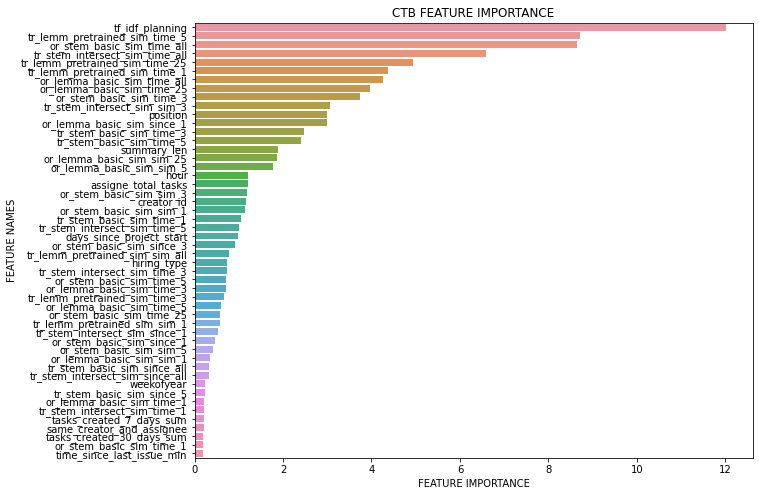

In [26]:
full_data_pool = Pool(train_df[use_cols], train_df[target_col], cat_features=cat_cols)
model_params['iterations'] = best_it

clf = CatBoostRegressor(**model_params)
clf.fit(
    full_data_pool,
    verbose=False,
    plot=False
);

shared_utils.plot_feature_importance(clf.get_feature_importance(), clf.feature_names_, 
                                     model_type = 'CTB ', top = 50)

## Inference & save

In [29]:
save_df = test_df.copy()
save_df['overall_worklogs'] = clf.predict(save_df[use_cols])
save_df = solution_df.drop(['overall_worklogs'], 1)\
    .merge(save_df[['id', 'overall_worklogs']], on = ['id'], how = 'inner', validate= '1:1')
assert save_df.shape[0] == solution_df.shape[0]
assert all(save_df['id'] == solution_df['id'])

# min value - 60 seconds
save_df['overall_worklogs'] = save_df['overall_worklogs'].apply(lambda x: max(60, x))

save_df.to_csv('./result/submission.csv', index = False)
save_df.head(3)

,id,overall_worklogs
0,675975,23554.812425
1,675972,9020.830516
2,675965,6211.366796
